In [1]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras

from keras import backend as K

np.__version__

# The methodology applied in this notebook is closely based on the methodology used for segmentation of flooded vs non-floode areas used here:
# https://www.kaggle.com/code/faizalkarim/flood-segmentation-unet


'1.23.5'

In [14]:
!python -V

Python 3.10.12


In [11]:
tf.__version__

'2.14.0'

In [12]:
!pip show keras

Name: keras
Version: 2.14.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install segmentation_models
!pip install  -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [3]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
import segmentation_models as sm
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5)
    # A.Blur(blur_limit = 3, p = 0.5),
    # A.RandomRotate90(p=1) ,
    # A.Rotate(limit=90,p=0.5) ,
    # A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

])

Segmentation Models: using `tf.keras` framework.


In [20]:
PATH = './drive/MyDrive/images/'

df = pd.read_csv(PATH + 'metadata.csv')
df.head()

,Image,Mask
0,_0.jpg,_0.png
1,_1.jpg,_1.png
2,_2.jpg,_2.png
3,_3.jpg,_3.png
4,_4.jpg,_4.png


In [21]:
df['Image'] = df['Image'].map(lambda x: PATH + 'relief/' + '_' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'masks/'+ '_' + x)

In [19]:
df.tail()

,Image,Mask
250,./drive/MyDrive/images/relief/__250.jpg,./drive/MyDrive/images/masks/__250.png
251,./drive/MyDrive/images/relief/__251.jpg,./drive/MyDrive/images/masks/__251.png
252,./drive/MyDrive/images/relief/__252.jpg,./drive/MyDrive/images/masks/__252.png
253,./drive/MyDrive/images/relief/__253.jpg,./drive/MyDrive/images/masks/__253.png
254,./drive/MyDrive/images/relief/__254.jpg,./drive/MyDrive/images/masks/__254.png


In [8]:
df.iloc[0,0], df.iloc[0,1]

('./drive/MyDrive/images/lidar/__0.jpg',
 './drive/MyDrive/images/masks/__0.png')

In [18]:
np.unique(plt.imread('./drive/MyDrive/images/lidar/__47.jpg'))

array([  0,   2, 187, 203, 206, 210, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 238, 255], dtype=uint8)

In [26]:
plt.imread('./drive/MyDrive/images/lidar/__47.jpg')/255

array([[[0.        , 0.        , 0.        , 1.        ],
        [0.8745098 , 0.8745098 , 0.8745098 , 1.        ],
        [0.86666667, 0.86666667, 0.86666667, 1.        ],
        ...,
        [0.85098039, 0.85098039, 0.85098039, 1.        ],
        [0.85098039, 0.85098039, 0.85098039, 1.        ],
        [0.85098039, 0.85098039, 0.85098039, 1.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.8745098 , 0.8745098 , 0.8745098 , 1.        ],
        [0.86666667, 0.86666667, 0.86666667, 1.        ],
        ...,
        [0.85098039, 0.85098039, 0.85098039, 1.        ],
        [0.85098039, 0.85098039, 0.85098039, 1.        ],
        [0.85098039, 0.85098039, 0.85098039, 1.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.8745098 , 0.8745098 , 0.8745098 , 1.        ],
        [0.86666667, 0.86666667, 0.86666667, 1.        ],
        ...,
        [0.85098039, 0.85098039, 0.85098039, 1.        ],
        [0.85098039, 0.850980

In [25]:
plt.imread('./drive/MyDrive/images/lidar/255.jpg')/255

array([[[0.2745098 , 0.3372549 , 0.2745098 , 1.        ],
        [0.20784314, 0.27843137, 0.28235294, 1.        ],
        [0.27058824, 0.3372549 , 0.3372549 , 1.        ],
        ...,
        [0.08627451, 0.15294118, 0.14509804, 1.        ],
        [0.05098039, 0.09019608, 0.08235294, 1.        ],
        [0.27058824, 0.3372549 , 0.3372549 , 1.        ]],

       [[0.27058824, 0.3372549 , 0.3372549 , 1.        ],
        [0.20784314, 0.27843137, 0.28235294, 1.        ],
        [0.22352941, 0.32156863, 0.22745098, 1.        ],
        ...,
        [0.08627451, 0.15294118, 0.14509804, 1.        ],
        [0.05098039, 0.09019608, 0.08235294, 1.        ],
        [0.29411765, 0.34901961, 0.39607843, 1.        ]],

       [[0.27058824, 0.3372549 , 0.3372549 , 1.        ],
        [0.22352941, 0.32156863, 0.22745098, 1.        ],
        [0.27058824, 0.3372549 , 0.3372549 , 1.        ],
        ...,
        [0.08627451, 0.15294118, 0.14509804, 1.        ],
        [0.05098039, 0.090196

In [70]:
np.unique(plt.imread('./drive/MyDrive/images/masks/__47.png'))

array([0.        , 0.00392157, 0.00784314], dtype=float32)

In [11]:
plt.imread('./drive/MyDrive/images/masks/__47.png').shape

(1501, 1501)

In [62]:
from PIL import Image
image = np.array(Image.open('./drive/MyDrive/images/lidar/__252.jpg'))
num_channels = image.shape[-1]

print(f"The image has {num_channels} channel(s).")

The image has 4 channel(s).


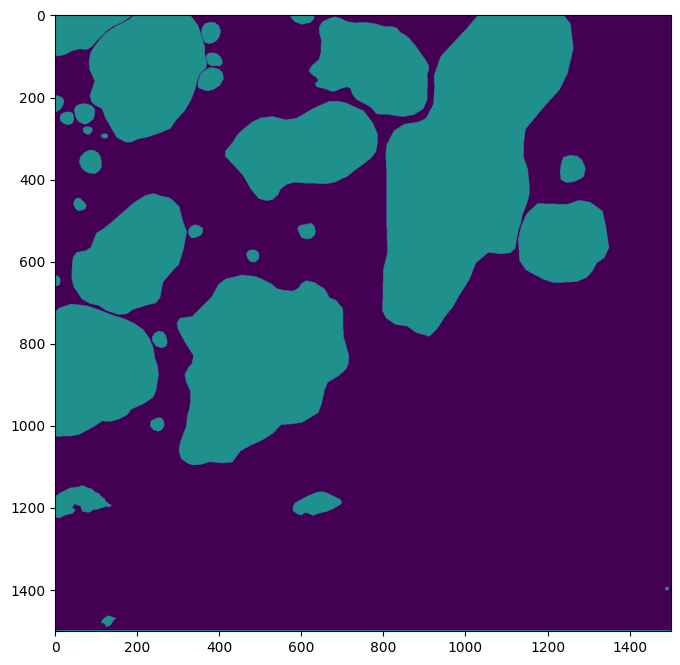

In [14]:
# example_mask  = np.where(plt.imread('./drive/MyDrive/images/masks_sparse/__47.png')> 0, 1, 0)
example_mask  = plt.imread('./drive/MyDrive/images/masks/__47.png')
plt.figure(figsize = (12,8))

plt.imshow(example_mask)


['./drive/MyDrive/images/relief/__143.jpg'] ['./drive/MyDrive/images/masks/__143.png']


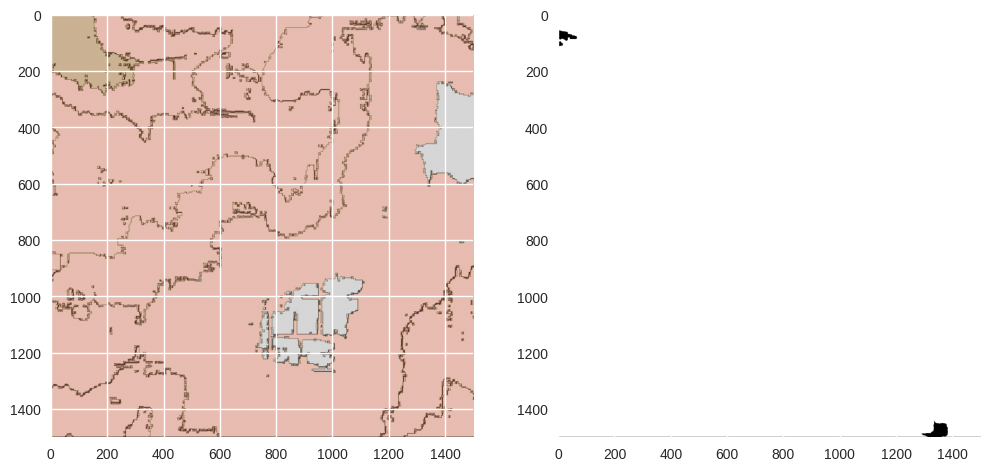

['./drive/MyDrive/images/relief/__93.jpg'] ['./drive/MyDrive/images/masks/__93.png']


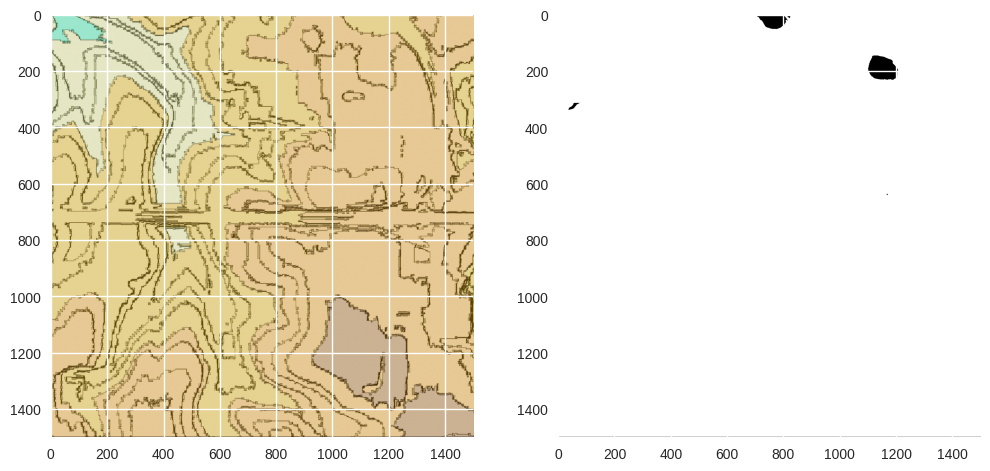

['./drive/MyDrive/images/relief/__16.jpg'] ['./drive/MyDrive/images/masks/__16.png']


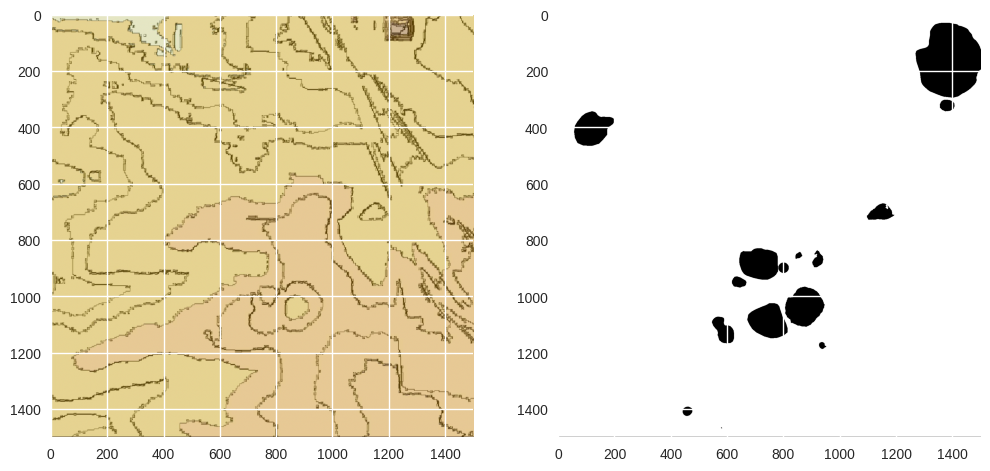

['./drive/MyDrive/images/relief/__124.jpg'] ['./drive/MyDrive/images/masks/__124.png']


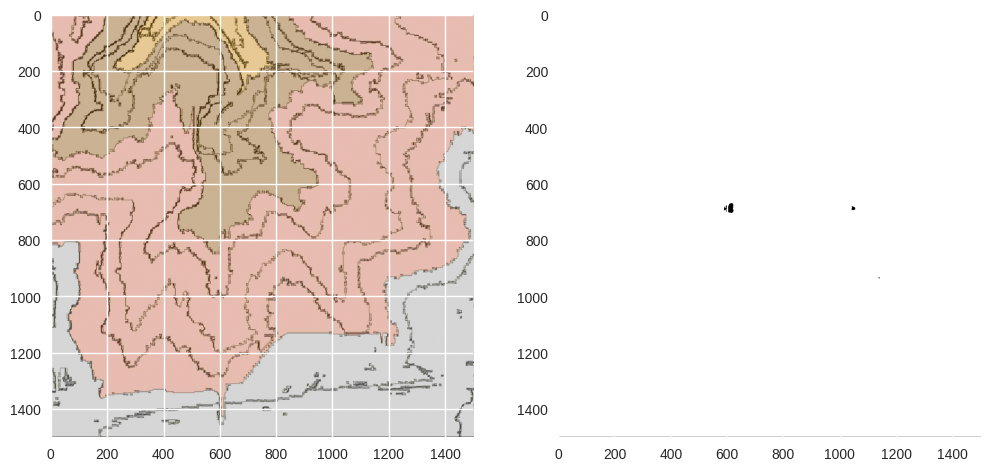

['./drive/MyDrive/images/relief/__128.jpg'] ['./drive/MyDrive/images/masks/__128.png']


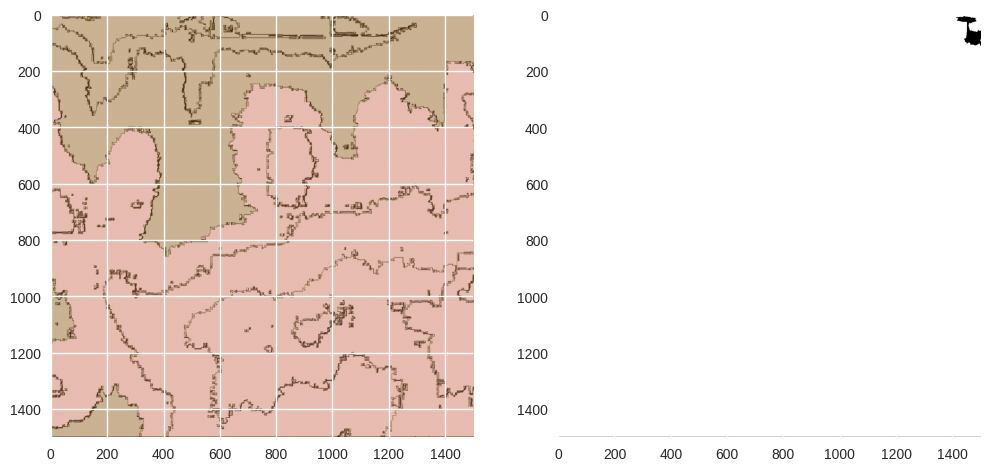

In [57]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)/255
    mask = np.where(plt.imread(sample.iloc[0, 1], 0)> 0, 1, 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

In [22]:
IMG_SIZE = (224, 224)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.00392157, 1)
    return t_mask

def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))

    img = img/255
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [33]:
type(plt.imread('./drive/MyDrive/images/lidar/__47.jpg'))

numpy.ndarray

In [ ]:
modify_mask(plt.imread('./drive/MyDrive/images/masks/__47.png'))

In [18]:
modify_mask(plt.imread('./drive/MyDrive/images/masks/__47.png')).shape

(1501, 1501, 1)

In [19]:
np.unique(modify_mask(plt.imread('./drive/MyDrive/images/masks/__47.png')))

array([0., 1.])

In [23]:
BATCH_SIZE = 16

def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [24]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state=42)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)

(229, 2) (26, 2)


In [25]:
model = sm.Unet('efficientnetb2',
                input_shape = (224,224,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')

In [26]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0002),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

NameError: ignored

In [15]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 25)

Epoch 1/25
15/15 [==============================] - 131s 4s/step - loss: 0.7721 - iou_score: 0.0141 - val_loss: 1.1004 - val_iou_score: 2.9163e-11
Epoch 2/25
15/15 [==============================] - 7s 441ms/step - loss: 0.5974 - iou_score: 0.0197 - val_loss: 1.4817 - val_iou_score: 2.8365e-11
Epoch 3/25
15/15 [==============================] - 7s 437ms/step - loss: 0.4934 - iou_score: 0.0198 - val_loss: 0.8738 - val_iou_score: 3.3961e-11
Epoch 4/25
15/15 [==============================] - 8s 510ms/step - loss: 0.4207 - iou_score: 0.0219 - val_loss: 0.8204 - val_iou_score: 3.3106e-11
Epoch 5/25
15/15 [==============================] - 8s 496ms/step - loss: 0.3756 - iou_score: 0.0235 - val_loss: 0.5530 - val_iou_score: 5.0410e-11
Epoch 6/25
15/15 [==============================] - 7s 443ms/step - loss: 0.3212 - iou_score: 0.0272 - val_loss: 0.3916 - val_iou_score: 5.3383e-11
Epoch 7/25
15/15 [==============================] - 9s 548ms/step - loss: 0.2816 - iou_score: 0.0313 - val_loss: 

In [16]:
model.save('./drive/MyDrive/images/sinkhole_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<ipython-input-72-9293f450f3f8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


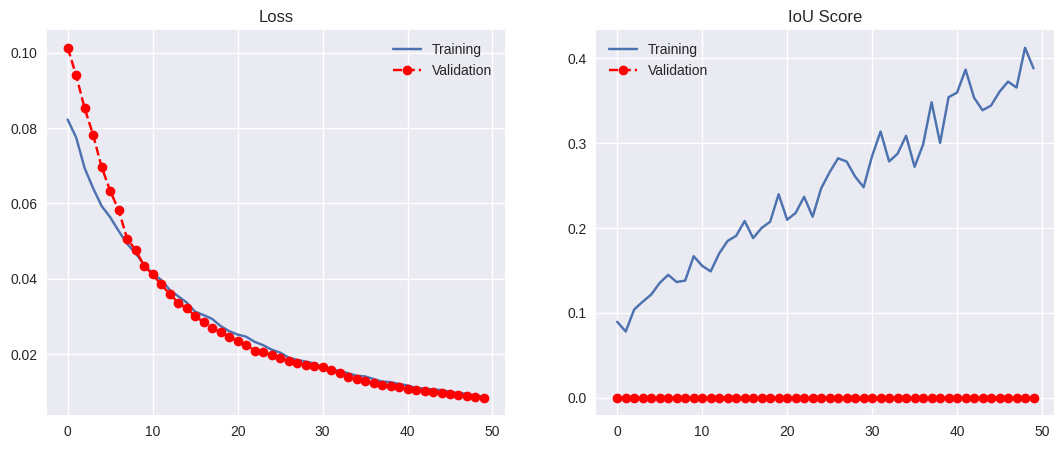

In [72]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()

In [74]:
# color = np.array([161, 205, 255])/255.0
# def make_pred_good(pred):
#     pred = pred[0][:, :]
#     pred = modify_mask(pred[:, :])
#     pred = np.repeat(pred, 3, 2)
#     return pred

# def placeMaskOnImg(img, mask):
#     np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
#     return img

color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(-0.5, 223.5, 223.5, -0.5)

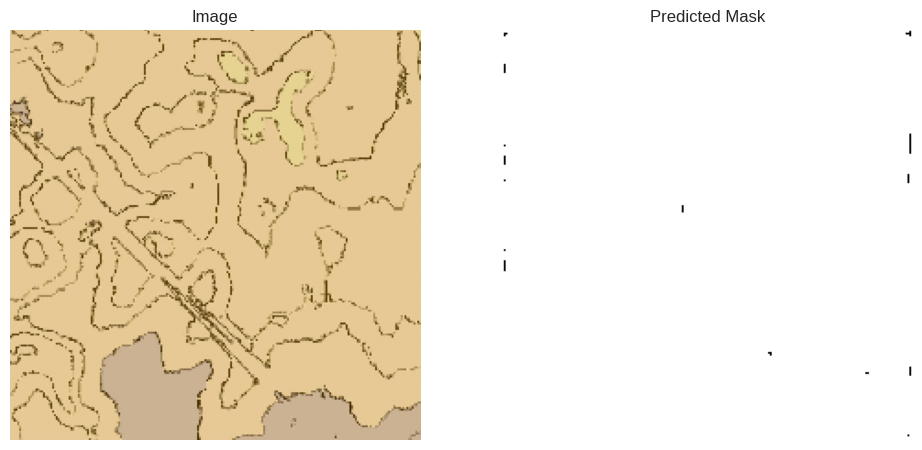

In [77]:
# url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
# import requests, io
# import numpy as np
# from PIL import Image

# response = requests.get(url)
# bytes_im = io.BytesIO(response.content)
img = plt.imread('./drive/MyDrive/images/relief/__47.jpg')

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

# plt.subplot(1,3,3)
# plt.title("Mask on Image")
# plt.imshow(placeMaskOnImg(img[0], pred))
# plt.axis('off')


In [62]:
# model.predict(plt.imread('./drive/MyDrive/images/lidar/__47.jpg')[:, :, :3])

make_pred_good(plt.imread('./drive/MyDrive/images/lidar/__47.jpg')).shape

# example_mask  = plt.imread('./drive/MyDrive/images/masks/__47.png')
# plt.figure(figsize = (12,8))
# plt.subplot(1,2,1)
# plt.imshow(example_mask)

(1501, 4, 3)

In [64]:
model.predict(plt.imread('./drive/MyDrive/images/lidar/__47.jpg'))

ValueError: ignored